In [ ]:
# %load tutorial.py
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.space import MultiGrid
from mesa.datacollection import DataCollector


def compute_gini(model):
    agent_wealths = [agent.wealth for agent in model.schedule.agents]
    x = sorted(agent_wealths)
    n = model.num_agents
    b = sum(xi * (n - i) for i, xi in enumerate(x)) / (n * sum(x))
    return 1 + (1 / n) - 2 * b


class MoneyAgent(Agent):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.wealth = 1

    def step(self):
        self.move()
        if self.wealth > 0:
            self.give_money()

    def move(self):
        possible_moves = self.model.grid.get_neighborhood(
            self.pos,
            moore=True,
            include_center=False)
        new_position = self.random.choice(possible_moves)
        self.model.grid.move_agent(self, new_position)

    def give_money(self):
        cellmates = self.model.grid.get_cell_list_contents([self.pos])
        if len(cellmates) > 1:
            other = self.random.choice(cellmates)
            other.wealth += 1
            self.wealth -= 1


class MoneyModel(Model):
    def __init__(self, n, width, height):
        super().__init__()
        self.running = True  # required by BatchRunner
        self.num_agents = n
        self.schedule = RandomActivation(self)
        self.grid = MultiGrid(width, height, True)

        for i in range(self.num_agents):
            a = MoneyAgent(i, self)
            self.schedule.add(a)
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(a, (x, y))

        self.datacollector = DataCollector(
            model_reporters={"Gini": compute_gini},
            agent_reporters={"Wealth": "wealth"})

    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()


In [13]:
model = MoneyModel(10)
for i in range(10):
    model.step()
    import matplotlib.pyplot as plt

agent_wealth = [a.wealth for a in model.schedule.agents]
plt.hist(agent_wealth)
plt.show()

(array([431., 302., 157.,  70.,  27.,  13.]),
 array([0, 1, 2, 3, 4, 5, 6]),
 <a list of 6 Patch objects>)

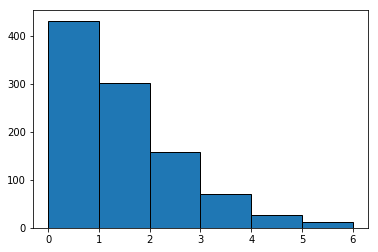

In [19]:
all_wealth = []
for j in range(100):
    # Run the model
    model = MoneyModel(10)
    for i in range(10):
        model.step()

    # Store the results
    for agent in model.schedule.agents:
        all_wealth.append(agent.wealth)

plt.hist(all_wealth, bins=range(max(all_wealth)+1), edgecolor='black')

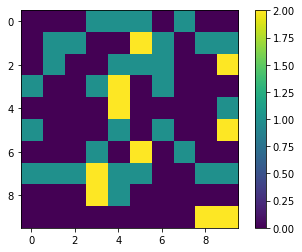

In [8]:
import numpy as np
model = MoneyModel(50, 10, 10)
for i in range(20):
    model.step()

agent_counts = np.zeros((model.grid.width, model.grid.height))
for cell in model.grid.coord_iter():
    cell_content, x, y = cell
    agent_count = len(cell_content)
    agent_counts[x][y] = agent_count
plt.imshow(agent_counts, interpolation='nearest')
plt.colorbar()

Wealth
Step AgentID        
0    0             1
     1             1
     2             1
     3             1
     4             1

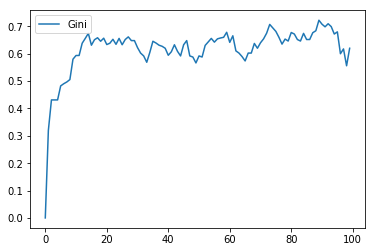

In [18]:
model = MoneyModel(50, 10, 10)
for i in range(100):
    model.step()
gini = model.datacollector.get_model_vars_dataframe()
gini.plot()

In [22]:
agent_wealth = model.datacollector.get_agent_vars_dataframe()
agent_wealth.head()

Wealth
Step AgentID        
0    0             1
     1             1
     2             1
     3             1
     4             1

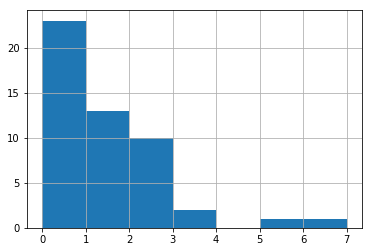

In [23]:
end_wealth = agent_wealth.xs(99, level="Step")["Wealth"]
end_wealth.hist(bins=range(agent_wealth.Wealth.max()+1))

In [2]:
from mesa.batchrunner import BatchRunner

fixed_params = {"width": 10,
                "height": 10}
variable_params = {"n": range(10, 500, 10)}

batch_run = BatchRunner(MoneyModel,
                        fixed_parameters=fixed_params,
                        variable_parameters=variable_params,
                        iterations=5,
                        max_steps=100,
                        model_reporters={"Gini": compute_gini})
batch_run.run_all()

245it [02:06,  1.03it/s]
